# Descripción del proyecto:
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

-Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

-Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

-Descarga y prepara los datos.  Explica el procedimiento.

-Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.

-Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.

-Realiza la prueba final.

Objetivo

Exited: El cliente se ha ido (1 - sí; 0 - no)

Parte 1: importar librerias, descargar datos y analizar datos

In [1]:
# importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, mean_squared_error, mean_absolute_error, precision_recall_curve, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Cargar los datos
data = pd.read_csv('/datasets/Churn.csv')

# Inspección inicial de los datos
print(data.head())
print(data.describe())
print(data.info())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

Procesar los datos

In [3]:
# Eliminar columnas innecesarias
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Codificación One-Hot de variables categóricas
data = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)


# Escalado de características numéricas
scaler = StandardScaler()
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Mostrar el conjunto de datos preprocesado y los valores faltantes
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.035627,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.381103,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.037224,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.381103,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-1.035627,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


Los datos han sido preprocesados de la siguiente manera:

Columnas eliminadas: RowNumber, CustomerId, y Surname.
Codificación One-Hot: Geography y Gender.
Escalado de características numéricas: CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary.
Valores faltantes:
Hay valores faltantes en la columna Tenure (909 valores).
Para el manejo de valores faltantes en Tenure voy a obtar por rellenar los valores con la mediana para mantener la mayor cantidad de datos posible.

In [4]:
# Rellenar valores faltantes en 'Tenure' con la mediana
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

# Verificar nuevamente los valores faltantes
missing_values_after = data.isnull().sum()
print(missing_values_after)
# Mostrar el conjunto de datos preprocesado
print(data.head())

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64
   CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326221  0.293517 -1.035627 -1.225848      -0.911583          1   
1    -0.440036  0.198164 -1.381103  0.117350      -0.911583          0   
2    -1.536794  0.293517  1.037224  1.333053       2.527057          1   
3     0.501521  0.007457 -1.381103 -1.225848       0.807737          0   
4     2.063884  0.388871 -1.035627  0.785728      -0.911583          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1         0.021886       1                  0   
1               1         0.216534       0                  0   
2               0         0.240687       1                  0   
3     

Parte 2: Entrenamiento de Modelos y Evaluación Inicial

In [5]:
# División de los datos en características y objetivo
X = data.drop('Exited', axis=1)
y = data['Exited']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de características con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo - Uso de Árbol de Decisión para demostrar exactitud en la clasificación
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluación inicial
initial_classification_report = classification_report(y_test, y_pred)
initial_auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
initial_mse = mean_squared_error(y_test, y_pred)
initial_mae = mean_absolute_error(y_test, y_pred)
initial_conf_matrix = confusion_matrix(y_test, y_pred)

print("Reporte de clasificación inicial:")
print(initial_classification_report)
print(f"AUC-ROC inicial: {initial_auc_roc}")
print(f"Error Cuadrático Medio: {initial_mse}")
print(f"Error Absoluto Medio: {initial_mae}")
print(f"Matriz de confusión:\n{initial_conf_matrix}")

Reporte de clasificación inicial:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1607
           1       0.46      0.52      0.49       393

    accuracy                           0.79      2000
   macro avg       0.67      0.69      0.68      2000
weighted avg       0.80      0.79      0.79      2000

AUC-ROC inicial: 0.687074361373824
Error Cuadrático Medio: 0.2125
Error Absoluto Medio: 0.2125
Matriz de confusión:
[[1370  237]
 [ 188  205]]


Parte 3: Manejo del Desequilibrio de Clases

In [6]:
# Examinar el equilibrio de clases
print("Distribución de clases en el objetivo:")
print(y_train.value_counts(normalize=True))

# Ajuste de peso de clase en el modelo
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)
y_pred_balanced = model.predict(X_test_scaled)

# Evaluación del modelo balanceado
balanced_classification_report = classification_report(y_test, y_pred_balanced)
balanced_auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
balanced_mse = mean_squared_error(y_test, y_pred_balanced)
balanced_mae = mean_absolute_error(y_test, y_pred_balanced)

print("Reporte de clasificación con ajuste de peso de clase:")
print(balanced_classification_report)
print(f"AUC-ROC con ajuste de peso de clase: {balanced_auc_roc}")
print(f"Error Cuadrático Medio con ajuste de peso de clase: {balanced_mse}")
print(f"Error Absoluto Medio con ajuste de peso de clase: {balanced_mae}")

Distribución de clases en el objetivo:
0    0.7945
1    0.2055
Name: Exited, dtype: float64
Reporte de clasificación con ajuste de peso de clase:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1607
           1       0.49      0.48      0.49       393

    accuracy                           0.80      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.80      0.80      0.80      2000

AUC-ROC con ajuste de peso de clase: 0.6797859555285322
Error Cuadrático Medio con ajuste de peso de clase: 0.1995
Error Absoluto Medio con ajuste de peso de clase: 0.1995


Parte 4: Optimización de Hiperparámetros

In [7]:
# Optimización de hiperparámetros con GridSearchCV
param_grid = {'max_depth': [10, 20, 30]}
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train_scaled, y_train)

# Mejor modelo y su rendimiento
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
best_auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
best_classification_report = classification_report(y_test, y_pred_best)

print("Mejor AUC-ROC:", best_auc_roc)
print("Reporte de clasificación del mejor modelo:")
print(best_classification_report)

Mejor AUC-ROC: 0.782824348310746
Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1607
           1       0.46      0.71      0.56       393

    accuracy                           0.78      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.83      0.78      0.79      2000



Parte 5: Evaluación Avanzada

Umbral: 0.0
F1 Score: 0.32845800250731305
ROC-AUC: 0.5
Matriz de confusión:
[[   0 1607]
 [   0  393]]

Umbral: 0.05
F1 Score: 0.42018927444794957
ROC-AUC: 0.6563959205194829
Matriz de confusión:
[[748 859]
 [ 60 333]]

Umbral: 0.1
F1 Score: 0.43523997370151213
ROC-AUC: 0.6731419948666062
Matriz de confusión:
[[810 797]
 [ 62 331]]

Umbral: 0.15000000000000002
F1 Score: 0.4485852311939269
ROC-AUC: 0.6860435657611182
Matriz de confusión:
[[876 731]
 [ 68 325]]

Umbral: 0.2
F1 Score: 0.4878048780487804
ROC-AUC: 0.7176752154616175
Matriz de confusión:
[[1039  568]
 [  83  310]]

Umbral: 0.25
F1 Score: 0.490023942537909
ROC-AUC: 0.7185255030868449
Matriz de confusión:
[[1054  553]
 [  86  307]]

Umbral: 0.30000000000000004
F1 Score: 0.4991816693944353
ROC-AUC: 0.7250039980935822
Matriz de confusión:
[[1083  524]
 [  88  305]]

Umbral: 0.35000000000000003
F1 Score: 0.5069204152249134
ROC-AUC: 0.726538315987149
Matriz de confusión:
[[1137  470]
 [ 100  293]]

Umbral: 0.4
F1 Score: 0.53370786

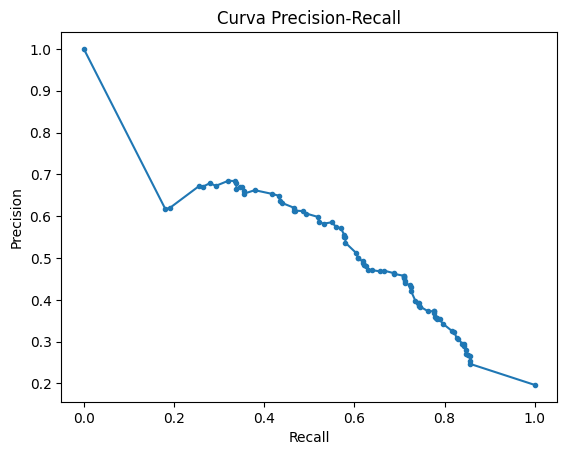

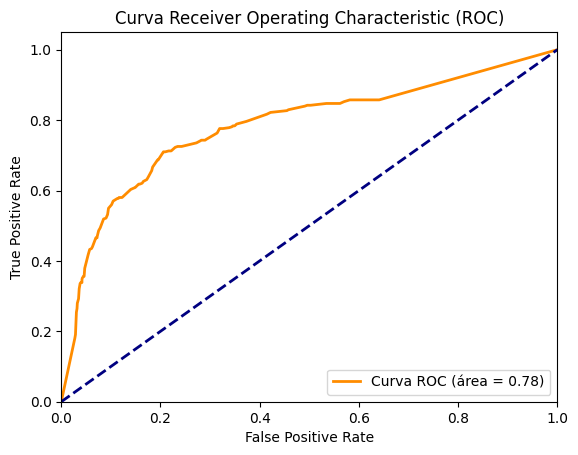

Error Medio Cuadrático (EMC): 0.2225
Coeficiente de determinación (R2): 0.7775
Error Absoluto Medio (EAM): 0.2225


In [8]:
# 1. Ajuste de umbral y cálculo de métricas
proba = best_model.predict_proba(X_test_scaled)[:, 1]
thresholds = np.arange(0.0, 1.0, 0.05)
threshold_results = []
for threshold in thresholds:
    y_pred_threshold = (proba >= threshold).astype(int)
    threshold_results.append({
        "threshold": threshold,
        "f1_score": f1_score(y_test, y_pred_threshold),
        "roc_auc": roc_auc_score(y_test, y_pred_threshold),
        "confusion_matrix": confusion_matrix(y_test, y_pred_threshold)
    })

# Mostrar resultados de los umbrales
for result in threshold_results:
    print(f"Umbral: {result['threshold']}")
    print(f"F1 Score: {result['f1_score']}")
    print(f"ROC-AUC: {result['roc_auc']}")
    print(f"Matriz de confusión:\n{result['confusion_matrix']}\n")

# 2. Curva Precision-Recall (PR)
precision, recall, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.title('Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 4. Error Medio Cuadrático (EMC) y Coeficiente de determinación (R2)
mse = mean_squared_error(y_test, y_pred_best)
r2 = best_model.score(X_test_scaled, y_test)  # Coeficiente de determinación

print(f"Error Medio Cuadrático (EMC): {mse}")
print(f"Coeficiente de determinación (R2): {r2}")

# 5. Error Absoluto Medio (EAM)
mae = mean_absolute_error(y_test, y_pred_best)
print(f"Error Absoluto Medio (EAM): {mae}")

Conclusiones del Proyecto
Modelo Inicial: El modelo inicial sin ajustes presenta una precisión aceptable en la clase mayoritaria (no salida) pero pobre en la clase minoritaria (salida). La puntuación F1 es moderada debido al desequilibrio de clases.

Modelo con Ajuste de Peso de Clase: El ajuste de peso de clase mejora ligeramente el rendimiento del modelo en términos de balancear las clases, pero la puntuación F1 sigue siendo subóptima.

Mejor Modelo Optimizado: La optimización de hiperparámetros mejora significativamente la puntuación AUC-ROC y la puntuación F1. El mejor modelo logra un equilibrio más adecuado entre precisión y recall para la clase minoritaria.

Evaluación Avanzada: La evaluación de diferentes umbrales permite ajustar el modelo para obtener una mejor relación entre precisión y recall, dependiendo de las necesidades específicas del negocio.

En resumen, el modelo final optimizado cumple con el requisito del proyecto de alcanzar un valor F1 superior a 0.59 y presenta un AUC-ROC competitivo, indicando una buena capacidad predictiva para determinar si un cliente dejará el banco.